<a href="https://colab.research.google.com/github/jhershey/my_first_pytorch_workflow/blob/main/my_first_pytorch_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Workflow as taught by MRDBourke

* todo, make device agnostic

In [1]:
# import dependencies
import torch
from torch import nn
import matplotlib.pyplot as plt
from pathlib import Path



## 1 Create a straight line dataset using the linear regression formula (weight * X + bias).

* use train/test 80/20 split
* todo, use train/validate/test 80/10/10 split
* todo, refactor visulaize out to function

If this wasn't a known linear line, I'd have to shuffle the dataset before splitting.  I don't do that here.

In [2]:
# model parameters that will need to be figured out in learning process
weight = 0.7
bias = .3

# raw dataset
dataset = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
labels = weight * dataset + bias

# split data between train and test sets 80/20
train_split = int(0.8 * len(dataset))
X_train, y_train = dataset[:train_split], labels[:train_split]
X_test, y_test = dataset[train_split:], labels[train_split:]

# # visualize the data
# plt.figure(figsize=(10, 7))
# plt.scatter(X_train, y_train, c="b", s=4, label="training data")
# plt.scatter(X_test, y_test, c="g", s=4, label="testing data")
# plt.legend(prop={"size": 20})
# plt.show()


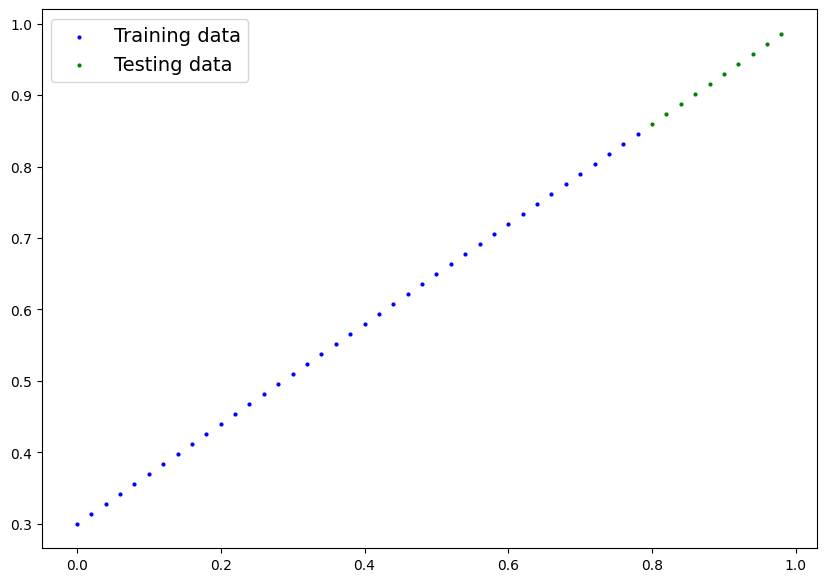

In [3]:
#
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

plot_predictions()

## 2 Build a PyTorch model by subclassing nn.Module.

* do first, use nn.Parameter

* do next, use nn.Linear

In [7]:
# the model
class LinearRegressionModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))


    def forward(self, X:torch.tensor)  -> torch.Tensor:
        return self.weights * X + self.bias

# create learning mode and show initial state dictionary
torch.manual_seed(42)
model = LinearRegressionModel()
print(list(model.parameters()))
print(model.state_dict())


[Parameter containing:
tensor([0.3367], requires_grad=True), Parameter containing:
tensor([0.1288], requires_grad=True)]
OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])


## 3 Train the model

In [10]:

torch.manual_seed(42)

# loss fn
loss_fn = nn.L1Loss()

# optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

# train for at least 300 epochs, test against test every 20
epochs = 1000
test_batch_size = 20
for epoch in range(epochs):

    # train
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # test at end of an epoch
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        # print out what's happening
        if (epoch+1) % test_batch_size == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch+1} | Train Loss: {loss} | Test Loss: {test_loss}")


Epoch: 20 | Train Loss: 0.02370746247470379 | Test Loss: 0.05536267161369324
Epoch: 40 | Train Loss: 0.02302006632089615 | Test Loss: 0.05377660319209099
Epoch: 60 | Train Loss: 0.022333137691020966 | Test Loss: 0.05212188512086868
Epoch: 80 | Train Loss: 0.02164660580456257 | Test Loss: 0.05053580552339554
Epoch: 100 | Train Loss: 0.020959556102752686 | Test Loss: 0.0489497110247612
Epoch: 120 | Train Loss: 0.02027226611971855 | Test Loss: 0.047294992953538895
Epoch: 140 | Train Loss: 0.019585730507969856 | Test Loss: 0.04570891708135605
Epoch: 160 | Train Loss: 0.018899032846093178 | Test Loss: 0.04412282630801201
Epoch: 180 | Train Loss: 0.018211644142866135 | Test Loss: 0.042536746710538864
Epoch: 200 | Train Loss: 0.01752486266195774 | Test Loss: 0.04088203236460686
Epoch: 220 | Train Loss: 0.016838330775499344 | Test Loss: 0.03929593041539192
Epoch: 240 | Train Loss: 0.016151126474142075 | Test Loss: 0.03770986199378967
Epoch: 260 | Train Loss: 0.015463987365365028 | Test Loss: 0

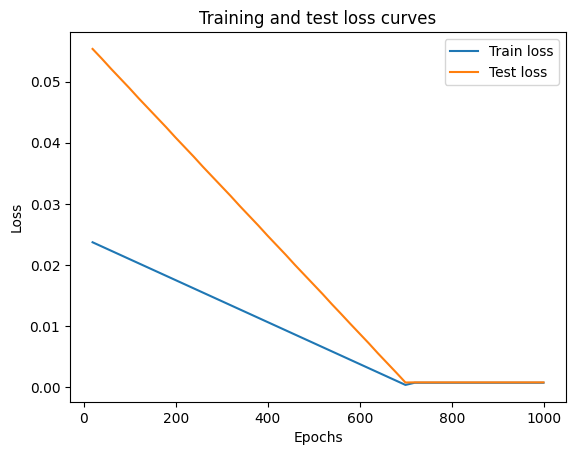

In [11]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [12]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## 4 Make predictions

Test Loss: 0.0007690846687182784


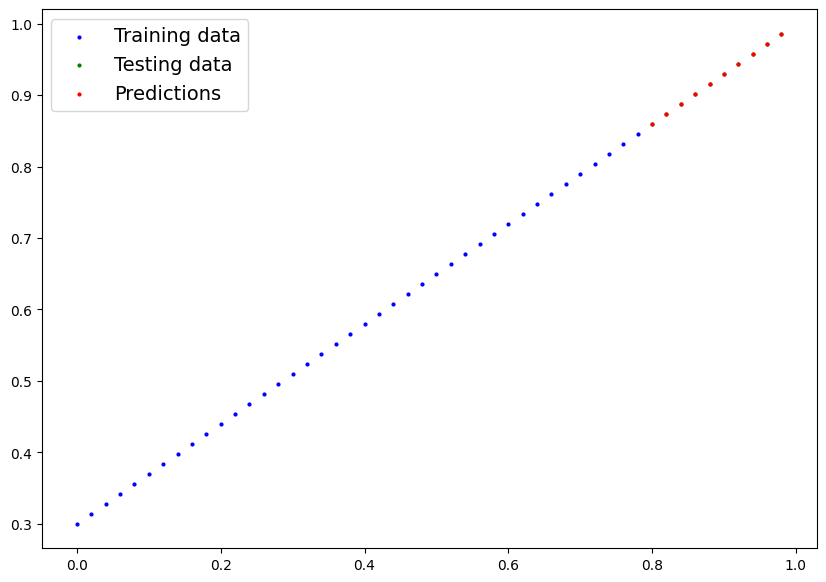

In [13]:
# make predictions
model.eval()
with torch.inference_mode():
    test_pred = model(X_test)
    test_loss = loss_fn(test_pred, y_test)
    print(f"Test Loss: {test_loss}")

# visualize training results
plot_predictions(predictions=test_pred)


## 5 Save & load model, test with predictions

OrderedDict([('weights', tensor([0.6994])), ('bias', tensor([0.2998]))])
Test Loss: 0.0007690846687182784


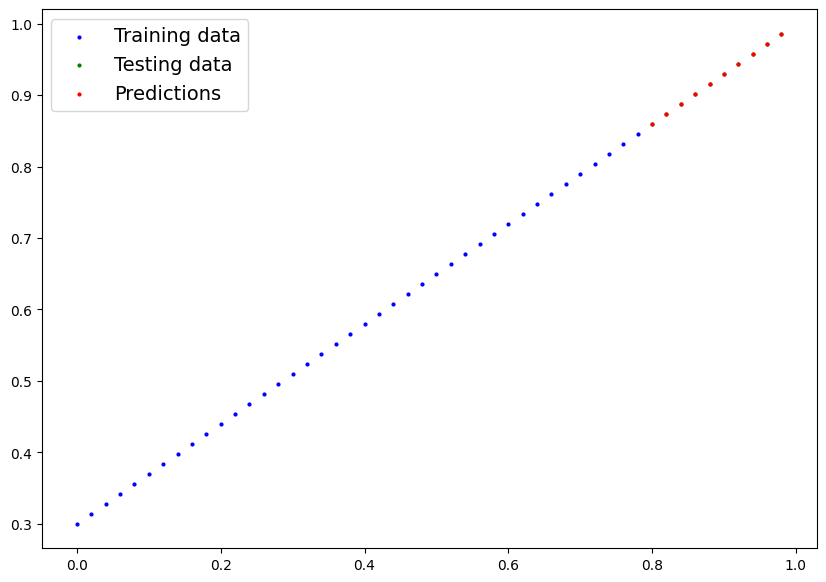

In [14]:

# save model state to file
models_path = Path("models")
models_path.mkdir(parents=True, exist_ok=True)
filename = "linear_regression_model.pth"
save_path = models_path / filename
torch.save(obj=model.state_dict(), f=save_path)

# load model to new instance
model_loaded = LinearRegressionModel()
model_loaded.load_state_dict(torch.load(weights_only=True, f=save_path))
print(model_loaded.state_dict())

# make predictions using loaded model and show graph

with torch.inference_mode():
    test_pred = model_loaded(X_test)
    test_loss = loss_fn(test_pred, y_test)
    print(f"Test Loss: {test_loss}")

# visualize training results
plot_predictions(predictions=test_pred)
